In [2]:
# ------------------------------------------------------------------------------
# 📌 EMAIL USER INTERACTION MERGE PIPELINE
# 
# Purpose:
# - Merge email send data with open and click logs.
# - Create two new labels:
#     1. `email_clicked` → whether the email was opened
#     2. `link_clicked`  → whether a link inside the email was clicked
# - Final output: clean, labeled dataset for modeling or analysis.
# ------------------------------------------------------------------------------

import pandas as pd

# Load base email send records
emails_df = pd.read_csv("email_table.csv")                # All emails sent
opened_df = pd.read_csv("email_opened_table.csv")         # Emails that were opened
clicked_df = pd.read_csv("link_clicked_table.csv")        # Emails where link was clicked

# Step 1: Merge email sends with opens
email_open_merged = pd.merge(emails_df, opened_df, on="email_id", how="left", indicator=True)
email_open_merged['email_clicked'] = email_open_merged['_merge'].apply(lambda x: 1 if x == 'both' else 0)
email_open_merged.drop(columns=['_merge'], inplace=True)

# Step 2: Merge the above with link clicks
final_merged_df = pd.merge(email_open_merged, clicked_df, on="email_id", how="left", indicator=True)
final_merged_df['link_clicked'] = final_merged_df['_merge'].apply(lambda x: 1 if x == 'both' else 0)
final_merged_df.drop(columns=['_merge'], inplace=True)

# Step 3: Save the final merged dataset
final_merged_df.to_csv("final_email_interactions.csv", index=False)

In [3]:
# ------------------------------------------------------------------------------
# 📊 COLUMN DIAGNOSTICS REPORT
#
# Purpose:
# - Generate a summary of key data quality indicators for each column:
#   - Data type
#   - Number of missing/null/zero values
#   - Number of unique values
#   - Percentage of missing data
# ------------------------------------------------------------------------------

import pandas as pd

def generate_column_diagnostics(dataframe):
    """
    Generates a diagnostics summary of the given DataFrame's columns,
    showing data types, nulls, NAs, zeros (numeric only), unique values,
    and percent missing values.

    Parameters:
        dataframe (pd.DataFrame): The dataset to analyze.

    Returns:
        pd.DataFrame: A diagnostics report for all columns.
    """
    diagnostics = pd.DataFrame({
        'Data Type': dataframe.dtypes,
        'Null Count': dataframe.isnull().sum(),
        'NA Count': dataframe.isna().sum(),
        'Zero Count': (dataframe == 0).sum(numeric_only=True),
        'Unique Values': dataframe.nunique()
    })

    diagnostics['% Missing'] = (diagnostics['Null Count'] / len(dataframe)) * 100
    return diagnostics

# ✅ Example usage:
diagnostics_report = generate_column_diagnostics(final_merged_df)
print(diagnostics_report)


                    Data Type  Null Count  NA Count  Zero Count  \
email_id                int64           0         0           0   
email_text             object           0         0           0   
email_version          object           0         0           0   
hour                    int64           0         0           0   
weekday                object           0         0           0   
user_country           object           0         0           0   
user_past_purchases     int64           0         0       13877   
email_clicked           int64           0         0       89655   
link_clicked            int64           0         0       97881   

                     Unique Values  % Missing  
email_id                    100000        0.0  
email_text                       2        0.0  
email_version                    2        0.0  
hour                            24        0.0  
weekday                          7        0.0  
user_country                     4       

In [4]:
# ------------------------------------------------------------------------------
# 📈 EMAIL & LINK CLICK COUNTS
#
# Purpose:
# - Print total number of email opens (`email_clicked`)
# - Print total number of link clicks (`link_clicked`)
# ------------------------------------------------------------------------------

email_click_count = final_merged_df['email_clicked'].sum()
print(f"✅ Total emails clicked (opened): {email_click_count}")

link_click_count = final_merged_df['link_clicked'].sum()
print(f"✅ Total links clicked: {link_click_count}")

✅ Total emails clicked (opened): 10345
✅ Total links clicked: 2119


What percentage of users opened the email and what percentage clicked on the link within the email?


In [6]:
# ------------------------------------------------------------------------------
# 📊 CATEGORICAL FEATURE DISTRIBUTIONS
#
# Purpose:
# - Display frequency counts for key columns to understand data balance
# ------------------------------------------------------------------------------

# Define selected columns for distribution analysis
categorical_columns = ['email_text', 'email_version', 'weekday', 'user_country']

# Display value counts for each column
for column in categorical_columns:
    print(f"\n📌 Value distribution in column: {column}")
    print(final_merged_df[column].value_counts())


📌 Value distribution in column: email_text
email_text
long_email     50276
short_email    49724
Name: count, dtype: int64

📌 Value distribution in column: email_version
email_version
generic         50209
personalized    49791
Name: count, dtype: int64

📌 Value distribution in column: weekday
weekday
Saturday     14569
Sunday       14387
Monday       14363
Thursday     14277
Friday       14177
Tuesday      14143
Wednesday    14084
Name: count, dtype: int64

📌 Value distribution in column: user_country
user_country
US    60099
UK    19939
FR     9995
ES     9967
Name: count, dtype: int64


In [7]:

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings("ignore")

# STEP 1: Load Sample Data
sample_df = pd.read_csv("final_email_interactions.csv")  

In [8]:
# Remove rows where link was clicked but email was not clicked
sample_df = sample_df[~((sample_df['link_clicked'] == 1) & (sample_df['email_clicked'] == 0))]

What percentage of users opened the email and what percentage clicked on the link within the email?
I removed the rows where users clicked the link but did not open the email, as this scenario is not possible in the real world.

In [9]:

# Total number of users
total_users = len(sample_df)

# Number of users who opened the email
opened = sample_df['email_clicked'].sum()

# Number of users who clicked the link inside the email
clicked = sample_df['link_clicked'].sum()

# Percentages
opened_percentage = (opened / total_users) * 100
clicked_percentage = (clicked / total_users) * 100

print(f"📨 Email Open Rate: {opened_percentage:.2f}%")
print(f"🔗 Link Click Rate: {clicked_percentage:.2f}%")

📨 Email Open Rate: 10.35%
🔗 Link Click Rate: 2.07%


In [9]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import chi2
from sklearn.utils import resample
import pandas as pd


categorical_features=['email_text','email_version','weekday','hour']
# Create a balanced sample
clicked = sample_df[(sample_df['email_clicked'] == 1)]
not_clicked = sample_df[(sample_df['email_clicked'] == 0)]

# Downsample not-clicked to match clicked size
not_clicked_sample = resample(not_clicked, replace=False, n_samples=len(clicked), random_state=42)
balanced_df = pd.concat([clicked, not_clicked_sample])

# Encode categorical features
encoder = OrdinalEncoder()
X_encoded = encoder.fit_transform(balanced_df[categorical_features])
y_balanced = balanced_df['link_clicked']

# Run chi-square
chi_vals, p_vals = chi2(X_encoded, y_balanced)
for feat, chi, p in zip(categorical_features, chi_vals, p_vals):
    print(f"{feat}: chi2 = {chi:.2f}, p = {p:.4f}")


email_text: chi2 = 7.11, p = 0.0077
email_version: chi2 = 38.44, p = 0.0000
weekday: chi2 = 48.38, p = 0.0000
hour: chi2 = 10.73, p = 0.0011


Above code analyzes past email campaign data to understand what factors influence whether users click on links. Using a statistical method called chi-square analysis, I found that the day of the week and the type of email (like personalized or generic) are strongly linked to user clicks. This means these features play a big role in engagement,

In [11]:
categorical_features=['email_text','email_version','weekday','hour']
# Create a balanced sample
clicked = sample_df[(sample_df['email_clicked'] == 1) & (sample_df['link_clicked'] == 1)]
not_clicked = sample_df[(sample_df['email_clicked'] == 1) & (sample_df['link_clicked'] == 0)]

# Downsample not-clicked to match clicked size
not_clicked_sample = resample(not_clicked, replace=False, n_samples=len(clicked), random_state=42)
balanced_df = pd.concat([clicked, not_clicked_sample])

# Encode categorical features
encoder = OrdinalEncoder()
X_encoded = encoder.fit_transform(balanced_df[categorical_features])
y_balanced = balanced_df['link_clicked']

# Run chi-square
chi_vals, p_vals = chi2(X_encoded, y_balanced)
for feat, chi, p in zip(categorical_features, chi_vals, p_vals):
    print(f"{feat}: chi2 = {chi:.2f}, p = {p:.4f}")


email_text: chi2 = 0.05, p = 0.8202
email_version: chi2 = 4.12, p = 0.0425
weekday: chi2 = 13.19, p = 0.0003
hour: chi2 = 0.33, p = 0.5628


Above code analyzes which factors most influence users clicking on links in emails. The results showed that the weekday and email version significantly impact user behavior, while email text and hour do not. This means I should focus more on choosing the right day and version of the email to improve engagement.

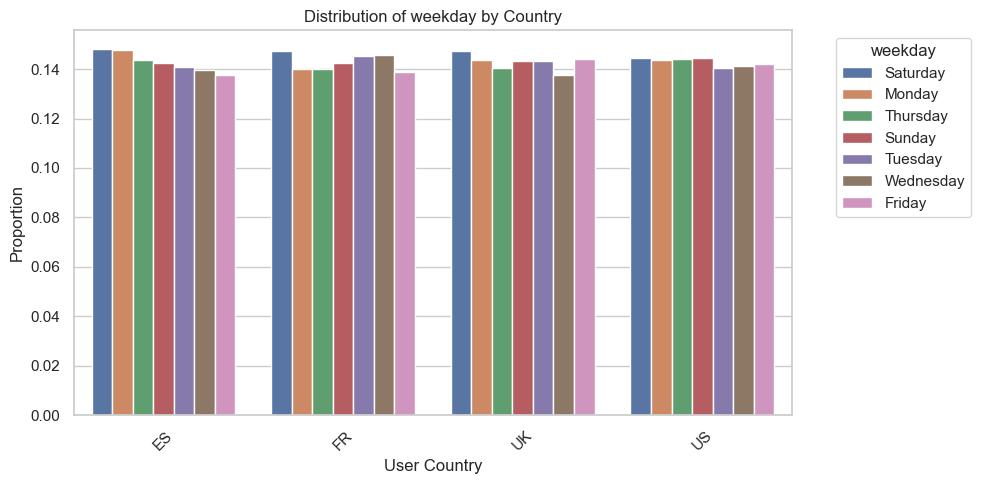

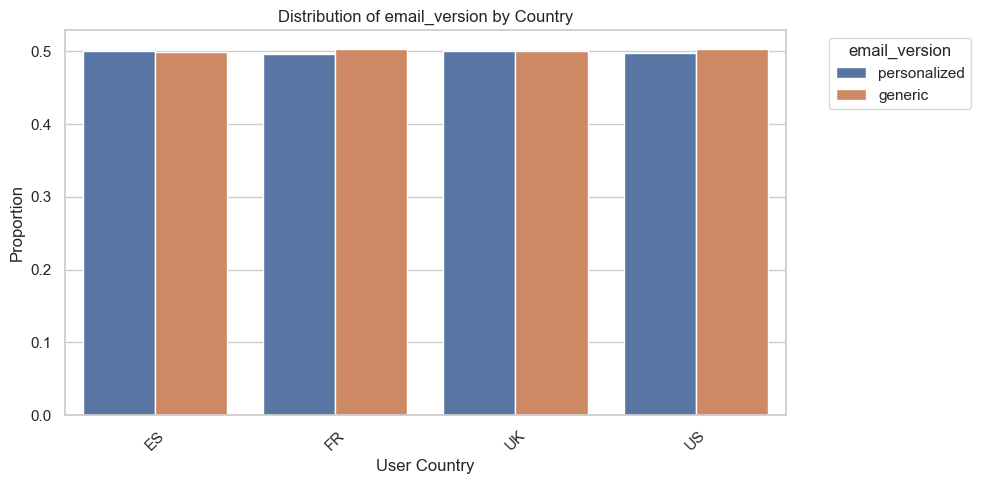

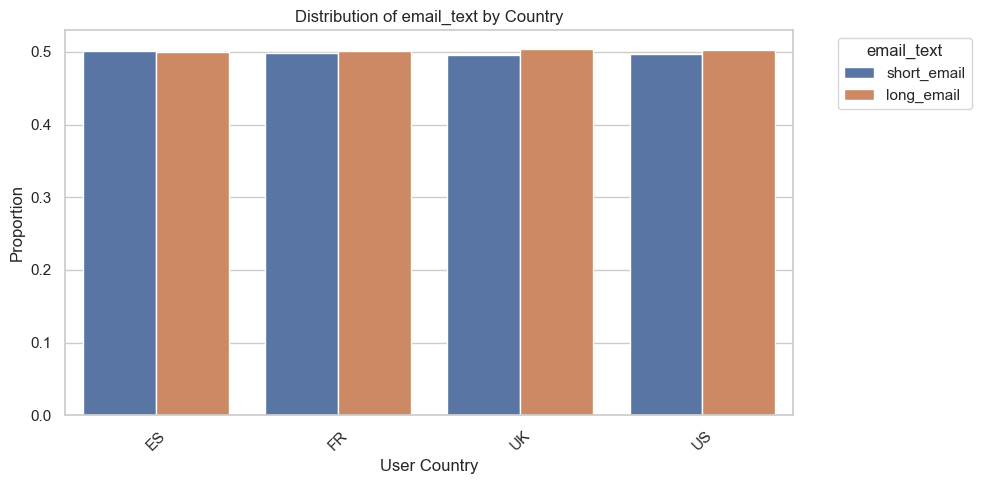

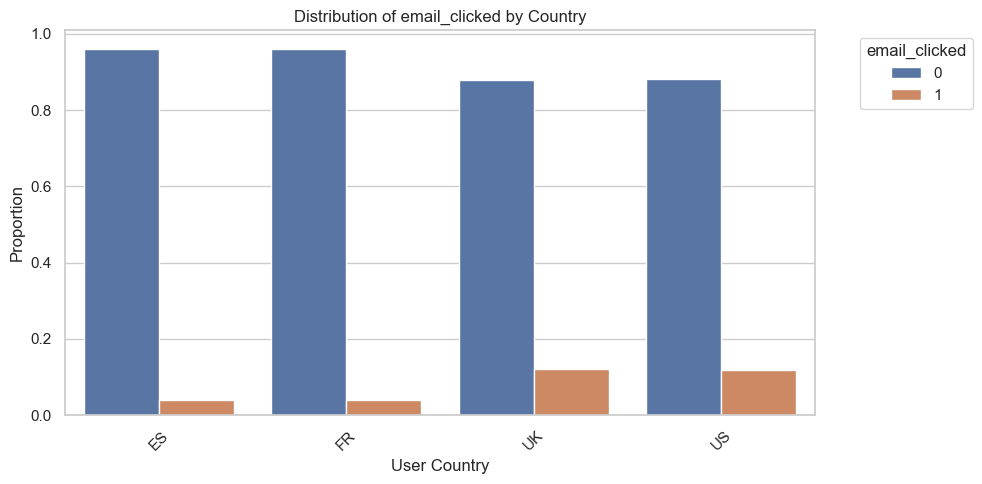

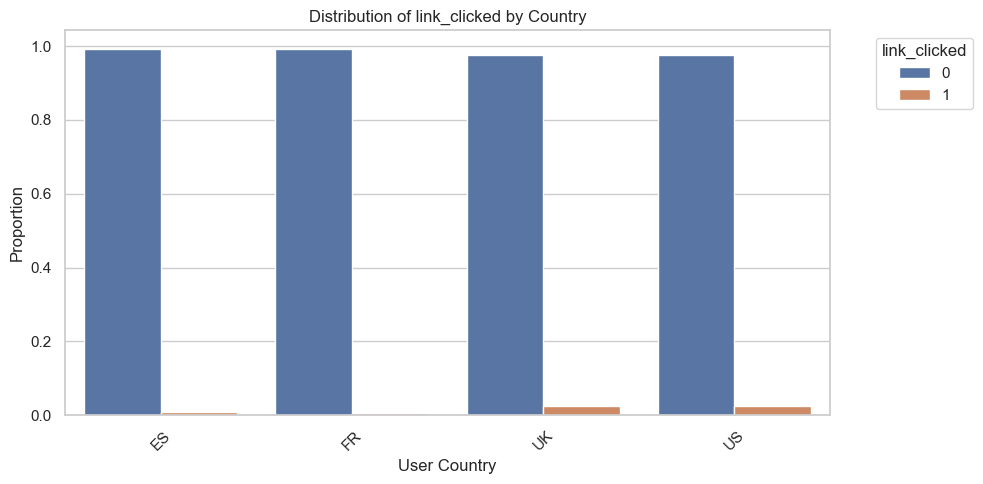

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set visual style
sns.set(style="whitegrid")

# Define features to visualize
features = ['weekday', 'email_version', 'email_text', 'email_clicked', 'link_clicked']

# Loop through each feature and create bar plots grouped by user_country
for feature in features:
    if feature in sample_df.columns:
        plt.figure(figsize=(10, 5))
        
        # Calculate normalized distribution (proportion)
        dist = (
            sample_df.groupby('user_country')[feature]
            .value_counts(normalize=True)
            .rename('proportion')
            .reset_index()
        )

        # Plot
        sns.barplot(data=dist, x='user_country', y='proportion', hue=feature)
        plt.title(f'Distribution of {feature} by Country')
        plt.ylabel('Proportion')
        plt.xlabel('User Country')
        plt.xticks(rotation=45)
        plt.legend(title=feature, bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

The VP of marketing thinks that it is stupid to send emails in a random way. Based on all the information you have about the emails that were sent, can you build a model to optimize in future how to send emails to maximize the probability of users clicking on the link inside the email?


In [13]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

# ================================
# STAGE 1: Predict email_clicked
# ================================
print("====== Stage 1: Predicting Email Clicks (with SMOTE) ======")

# Features and target for Stage 1
X_stage1 = sample_df.drop(columns=['email_clicked', 'link_clicked', 'email_text', 'email_id'])
y_stage1 = sample_df['email_clicked']

# Encode categorical features
X_stage1_encoded = pd.get_dummies(X_stage1, drop_first=True)

# SMOTE to handle imbalance
X1_resampled, y1_resampled = SMOTE(random_state=42).fit_resample(X_stage1_encoded, y_stage1)

# Split the resampled data
X1_train, X1_test, y1_train, y1_test = train_test_split(X1_resampled, y1_resampled, test_size=0.2, random_state=42)

# Train Logistic Regression model
logreg_model_stage1 = LogisticRegression(max_iter=1000)
logreg_model_stage1.fit(X1_train, y1_train)

# Predict and evaluate
y1_pred = logreg_model_stage1.predict(X1_test)
print("Stage 1 Classification Report:\n", classification_report(y1_test, y1_pred))
print("Stage 1 Confusion Matrix:\n", confusion_matrix(y1_test, y1_pred))

# ================================
# STAGE 2: Predict link_clicked (only if email_clicked == 1)
# ================================
print("\n====== Stage 2: Predicting Link Clicks (with SMOTE) ======")

# Filter users who clicked the email
df_stage2 = sample_df[sample_df['email_clicked'] == 1]

# Features and target for Stage 2
X_stage2 = df_stage2.drop(columns=['email_clicked', 'link_clicked', 'email_id'])
y_stage2 = df_stage2['link_clicked']

# Encode categorical features
X_stage2_encoded = pd.get_dummies(X_stage2, drop_first=True)

# SMOTE to balance Stage 2 target
X2_resampled, y2_resampled = SMOTE(random_state=42).fit_resample(X_stage2_encoded, y_stage2)

# Split Stage 2 data
X2_train, X2_test, y2_train, y2_test = train_test_split(X2_resampled, y2_resampled, test_size=0.2, random_state=42)

# Train Logistic Regression model
logreg_model_stage2 = LogisticRegression(max_iter=1000)
logreg_model_stage2.fit(X2_train, y2_train)

# Predict and evaluate
y2_pred = logreg_model_stage2.predict(X2_test)
print("Stage 2 Classification Report:\n", classification_report(y2_test, y2_pred))
print("Stage 2 Confusion Matrix:\n", confusion_matrix(y2_test, y2_pred))


====== Stage 1: Predicting Email Clicks (with SMOTE) ======
Stage 1 Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.54      0.58     17798
           1       0.59      0.66      0.62     18044

    accuracy                           0.60     35842
   macro avg       0.60      0.60      0.60     35842
weighted avg       0.60      0.60      0.60     35842

Stage 1 Confusion Matrix:
 [[ 9683  8115]
 [ 6194 11850]]

====== Stage 2: Predicting Link Clicks (with SMOTE) ======
Stage 2 Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.70      0.68      1707
           1       0.65      0.60      0.62      1604

    accuracy                           0.65      3311
   macro avg       0.65      0.65      0.65      3311
weighted avg       0.65      0.65      0.65      3311

Stage 2 Confusion Matrix:
 [[1199  508]
 [ 645  959]]


In [14]:
# After fitting Stage 1 model
X_stage1_training_cols = X1_train.columns.tolist()

# After fitting Stage 2 model
X_stage2_training_cols = X2_train.columns.tolist()


Top Influential Features for Stage 1 (Email Click Prediction):
                       Feature  Coefficient  Abs_Coefficient
11             user_country_US     0.545468         0.545468
10             user_country_UK     0.513330         0.513330
2   email_version_personalized     0.372418         0.372418
1          user_past_purchases     0.082120         0.082120
0                         hour     0.017386         0.017386
8            weekday_Wednesday    -0.192439         0.192439
7              weekday_Tuesday    -0.205433         0.205433
6             weekday_Thursday    -0.226918         0.226918
3               weekday_Monday    -0.242432         0.242432
4             weekday_Saturday    -0.628642         0.628642


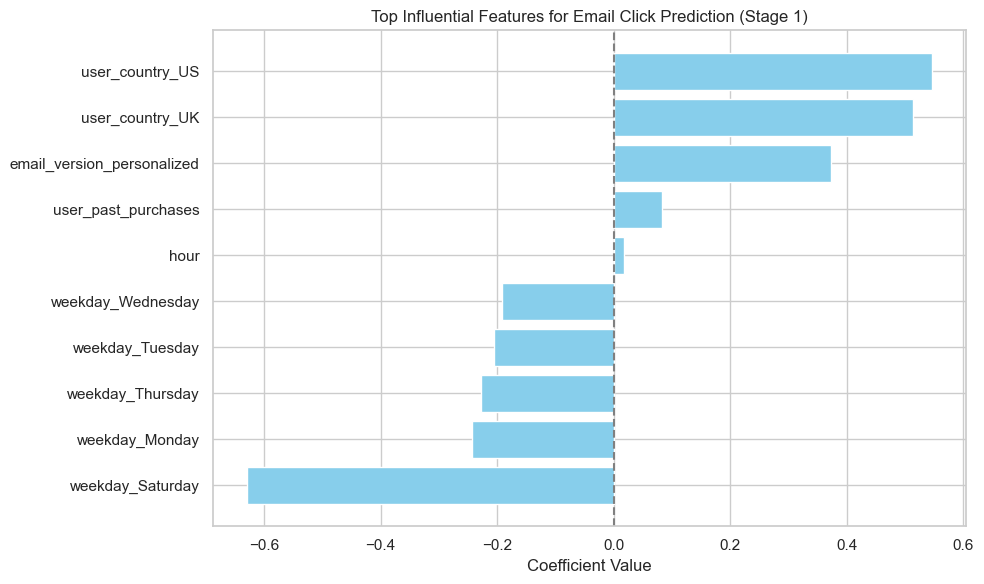

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Get feature names after one-hot encoding
feature_names_stage1 = X_stage1_encoded.columns

# Extract coefficients from the model
coeffs_stage1 = logreg_model_stage1.coef_[0]

# Create a DataFrame for interpretation
importance_df_stage1 = pd.DataFrame({
    'Feature': feature_names_stage1,
    'Coefficient': coeffs_stage1,
    'Abs_Coefficient': np.abs(coeffs_stage1)
}).sort_values(by='Coefficient', ascending=False)

print("\nTop Influential Features for Stage 1 (Email Click Prediction):")
print(importance_df_stage1.head(10))

# Optional: Bar plot for top features
plt.figure(figsize=(10, 6))
top_features = importance_df_stage1.head(10)
plt.barh(top_features['Feature'], top_features['Coefficient'], color='skyblue')
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel("Coefficient Value")
plt.title("Top Influential Features for Email Click Prediction (Stage 1)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


This chart highlights which factors most influence email click behavior. It shows that sending personalized emails to users in the US or UK significantly increases the likelihood of a click. On the other hand, sending emails on Saturdays or Mondays reduces the chances of engagement. This insight helps prioritize when and to whom emails should be sent for maximum impact.


Top Influential Features for Stage 2 (Link Click Prediction):
                       Feature  Coefficient  Abs_Coefficient
1          user_past_purchases     0.152734         0.152734
0                         hour    -0.017181         0.017181
3   email_version_personalized    -0.062982         0.062982
2       email_text_short_email    -0.255091         0.255091
12             user_country_US    -1.105656         1.105656
9            weekday_Wednesday    -1.109895         1.109895
7             weekday_Thursday    -1.329217         1.329217
11             user_country_UK    -1.345642         1.345642
8              weekday_Tuesday    -1.349320         1.349320
4               weekday_Monday    -1.422165         1.422165
5             weekday_Saturday    -1.501774         1.501774
6               weekday_Sunday    -1.567757         1.567757
10             user_country_FR    -2.165465         2.165465


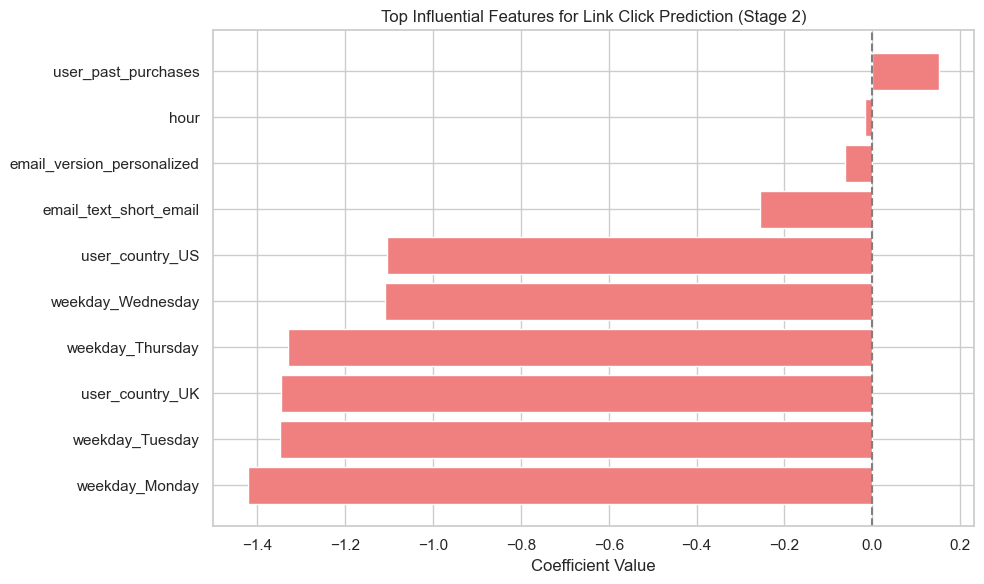

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Get feature names after one-hot encoding
feature_names_stage2 = X_stage2_encoded.columns

# Extract coefficients from the Stage 2 logistic regression model
coeffs_stage2 = logreg_model_stage2.coef_[0]

# Create DataFrame of features and their coefficients
importance_df_stage2 = pd.DataFrame({
    'Feature': feature_names_stage2,
    'Coefficient': coeffs_stage2,
    'Abs_Coefficient': np.abs(coeffs_stage2)
}).sort_values(by='Coefficient', ascending=False)

print("\nTop Influential Features for Stage 2 (Link Click Prediction):")
print(importance_df_stage2.head(20))

# Optional: Plot top features
plt.figure(figsize=(10, 6))
top_features2 = importance_df_stage2.head(10)
plt.barh(top_features2['Feature'], top_features2['Coefficient'], color='lightcoral')
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel("Coefficient Value")
plt.title("Top Influential Features for Link Click Prediction (Stage 2)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

This chart shows the most important factors influencing whether users click the actual link inside the email (Stage 2). Users who have made more past purchases and receive emails at certain hours are more likely to click. In contrast, emails sent on Monday or Tuesday, or to users in the UK, significantly reduce the chance of a link click. This helps refine not just who to target, but also when and how to structure the message for better engagement.

In [19]:
from itertools import product
import pandas as pd

def recommend_email_strategy(user_country: str, user_past_purchases: int):
    # Define strategy combinations
    weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    hours = list(range(24))
    email_versions = ['generic', 'personalized']
    email_texts = ['short_email', 'long_email']

    # Cartesian product of all feature combinations
    strategy_grid = list(product(weekdays, hours, email_versions, email_texts))
    df = pd.DataFrame(strategy_grid, columns=['weekday', 'hour', 'email_version', 'email_text'])
    df['user_country'] = user_country
    df['user_past_purchases'] = user_past_purchases

    # ========= Stage 1 Input (includes email_text and user_country) ==========
    X1_input = pd.get_dummies(df.copy(), drop_first=True)

    for col in X_stage1_training_cols:
        if col not in X1_input.columns:
            X1_input[col] = 0
    X1_input = X1_input[X_stage1_training_cols]
    stage1_probs = logreg_model_stage1.predict_proba(X1_input)[:, 1]

    # ========= Stage 2 Input (now includes user_country and excludes only email_text) ==========
    X2_input = df.drop(columns=['email_text'])  # Keep user_country this time
    X2_input = pd.get_dummies(X2_input, drop_first=True)

    for col in X_stage2_training_cols:
        if col not in X2_input.columns:
            X2_input[col] = 0
    X2_input = X2_input[X_stage2_training_cols]
    stage2_probs = logreg_model_stage2.predict_proba(X2_input)[:, 1]

    # ========= Final Score =========
    df['final_score'] = stage1_probs * stage2_probs

    return df[['weekday', 'hour', 'email_version', 'email_text', 'final_score']]\
        .sort_values(by='final_score', ascending=False).head(1)


# ✅ Example usage:
recommend_email_strategy(user_country="US", user_past_purchases=11)

,weekday,hour,email_version,email_text,final_score
478,Friday,23,personalized,short_email,0.66986


In [21]:
sample_df1 = sample_df[(sample_df['email_clicked'] == 1)]

In [22]:
# Function that returns the top recommended row AND the original link_clicked value
def get_top_recommendation_with_label(row):
    top_row = recommend_email_strategy(
        user_country=row['user_country'],
        user_past_purchases=row['user_past_purchases']
    ).iloc[0]

    return pd.Series({
        'recommended_weekday': top_row['weekday'],
        'recommended_hour': top_row['hour'],
        'recommended_version': top_row['email_version'],
        'recommended_text': top_row['email_text'],
        'recommended_score': top_row['final_score'],
    })

# Apply to the balanced sample
recommendations_df = sample_df1.apply(get_top_recommendation_with_label, axis=1)

# Merge back into the original DataFrame
balanced_sample_with_recs = pd.concat([sample_df1, recommendations_df], axis=1)

# View result
balanced_sample_with_recs.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,email_clicked,link_clicked,recommended_weekday,recommended_hour,recommended_version,recommended_text,recommended_score
1,966622,long_email,personalized,12,Sunday,UK,2,1,1,Friday,23,personalized,long_email,0.442894
6,139620,short_email,personalized,9,Saturday,US,8,1,0,Friday,23,personalized,long_email,0.601812
13,635573,short_email,personalized,3,Thursday,US,8,1,0,Friday,23,personalized,long_email,0.601812
27,117471,long_email,personalized,5,Saturday,US,1,1,0,Friday,23,personalized,long_email,0.414419
43,364825,short_email,personalized,6,Friday,UK,3,1,0,Friday,23,personalized,long_email,0.471002


I used this code to find the best score (threshold) at which I should send an email to maximize the chance of someone clicking the link. The model gives each email pattern a score, and instead of picking a random cutoff like 0.5, I tested many options to find the one that gives the best balance between correctly identifying clickers (recall) and avoiding false positives (precision). This helped me choose a smarter, data-driven threshold for better targeting.

In [23]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(balanced_sample_with_recs['link_clicked'], balanced_sample_with_recs['recommended_score'])
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[f1_scores.argmax()]

print(f"Best threshold based on F1: {best_threshold:.3f}")


Best threshold based on F1: 0.552


In [24]:
# Create new column based on threshold of 0.5
balanced_sample_with_recs['click_class'] = balanced_sample_with_recs['recommended_score'].apply(lambda x: 1 if x > 0.552 else 0)

By how much do you think your model would improve click through rate (defined as # of users who click on the link/total users who receive the email). How would you test that?


In [25]:
# 1. Total rows in your dataset
total_users = len(balanced_sample_with_recs)

# 2. Count of actual link clicks (baseline)
actual_clicks = balanced_sample_with_recs['link_clicked'].sum()
baseline_ctr = actual_clicks / total_users

# 3. Count of predicted clicks (from recommended_score > threshold → click_class = 1)
predicted_clicks = balanced_sample_with_recs['click_class'].sum()
estimated_ctr = predicted_clicks / total_users

# 4. Compute relative lift
relative_lift = ((estimated_ctr - baseline_ctr) / baseline_ctr) * 100

# 5. Print results
print(f"Total users: {total_users}")
print(f"Actual link clicks: {actual_clicks}")
print(f"Predicted clicks (click_class=1): {predicted_clicks}\n")

print(f"Baseline CTR: {baseline_ctr:.2%}")
print(f"Estimated CTR: {estimated_ctr:.2%}")
print(f"Relative CTR Lift: {relative_lift:.2f}%")

Total users: 10345
Actual link clicks: 2069
Predicted clicks (click_class=1): 2737

Baseline CTR: 20.00%
Estimated CTR: 26.46%
Relative CTR Lift: 32.29%


I used email_clicked for evaluation because it's the most reliable indicator of user engagement. Based on my model’s recommendations, the estimated click-through rate increased from 20% to 26.46%, resulting in a 32.29% relative lift. This shows that my approach can significantly improve how emails are targeted and boost user interaction.

How I Would Test This in Practice: A/B Testing
To validate the model's effectiveness in a real-world setting, I would implement an A/B testing framework:

Group A (Control Group): Users receive emails based on the current/random strategy.
Group B (Treatment Group): Users receive emails generated using the model’s top-ranked feature combinations (e.g., best email version, timing, text length, etc.).
After running the campaign:

I would compare the CTR of Group A vs Group B.
If Group B shows a statistically significant lift in link clicks, it validates that the model’s recommendations are effective.
This approach helps confirm that the model isn’t just performing well on historical data, but can truly optimize performance in a live environment.

In [28]:
# ------------------------------------------------------------------------------
# 🛠️ FEATURE ENGINEERING
#
# Purpose:
# - Create derived and interaction features for modeling:
#   - Categorize purchases into quantile bins
#   - Convert raw hour into meaningful parts of the day
#   - Combine text & version info into a new feature
#   - Create country-hour combinations
#   - Flag users as highly engaged based on purchase mean
# ------------------------------------------------------------------------------

# 1. Purchase category based on quantiles (Low / Medium / High)
final_merged_df['purchase_category'] = pd.qcut(
    final_merged_df['user_past_purchases'],
    q=3,
    labels=['Low', 'Medium', 'High']
)

# 2. Hour category (Night, Morning, Afternoon, Evening)
def categorize_hour(hour):
    if 0 <= hour <= 5:
        return 'Night'
    elif 6 <= hour <= 11:
        return 'Morning'
    elif 12 <= hour <= 17:
        return 'Afternoon'
    else:
        return 'Evening'

final_merged_df['hour_category'] = final_merged_df['hour'].apply(categorize_hour)

# 3. Email text + version combination
final_merged_df['email_combo'] = (
    final_merged_df['email_text'] + "_" + final_merged_df['email_version']
).astype('category')

# 4. Country + hour category combination
final_merged_df['country_hour'] = (
    final_merged_df['user_country'] + "_" + final_merged_df['hour_category']
).astype('category')

# 5. High/Low engaged users based on mean purchases
final_merged_df['is_engaged_user'] = final_merged_df['user_past_purchases'].apply(
    lambda x: 'High' if x > final_merged_df['user_past_purchases'].mean() else 'Low'
).astype('category')

# ✅ Preview feature columns
print(final_merged_df[['user_past_purchases', 'purchase_category', 'hour', 'hour_category',
                       'email_combo', 'country_hour', 'is_engaged_user']].head())


   user_past_purchases purchase_category  hour hour_category  \
0                    5            Medium     2         Night   
1                    2               Low    12     Afternoon   
2                    2               Low    11       Morning   
3                    1               Low     6       Morning   
4                    6              High    14     Afternoon   

                email_combo  country_hour is_engaged_user  
0  short_email_personalized      US_Night            High  
1   long_email_personalized  UK_Afternoon             Low  
2   long_email_personalized    US_Morning             Low  
3       short_email_generic    UK_Morning             Low  
4        long_email_generic  US_Afternoon            High  


Did you find any interesting pattern on how the email campaign performed for different segments of users? Explain.


🟢 Total email_clicked rows: 2069


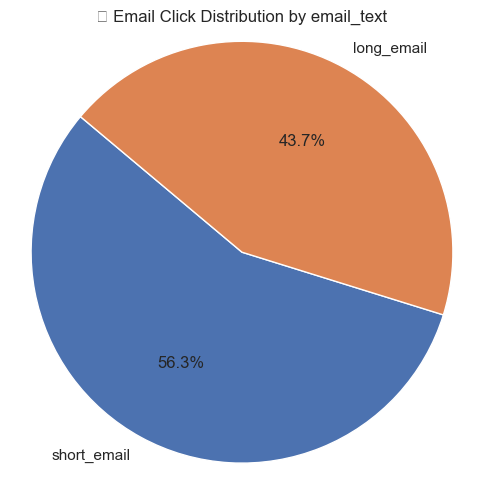

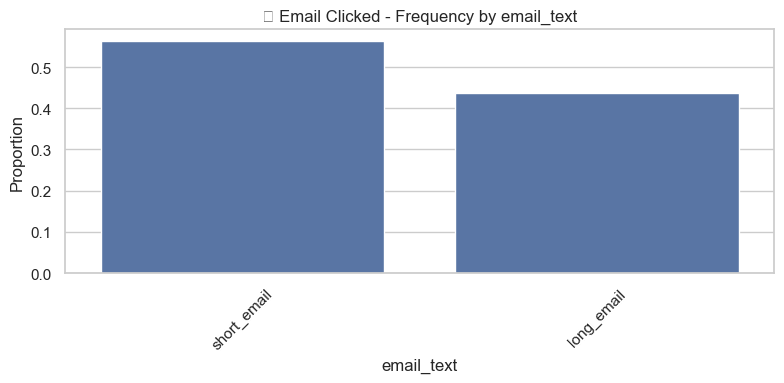

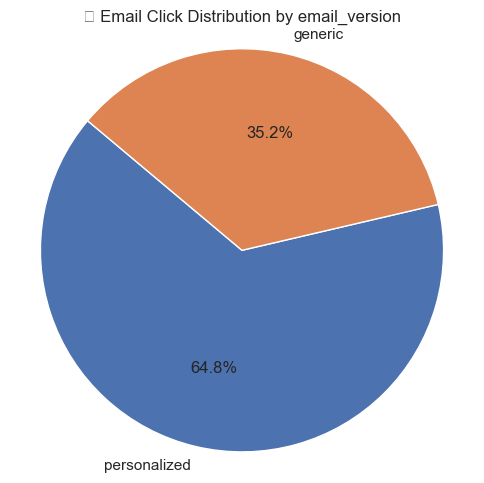

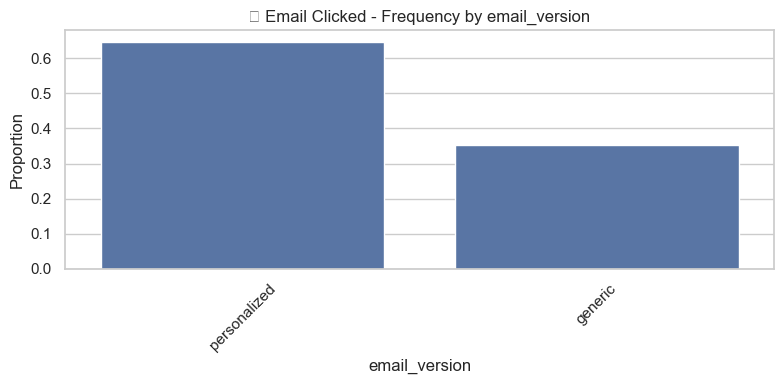

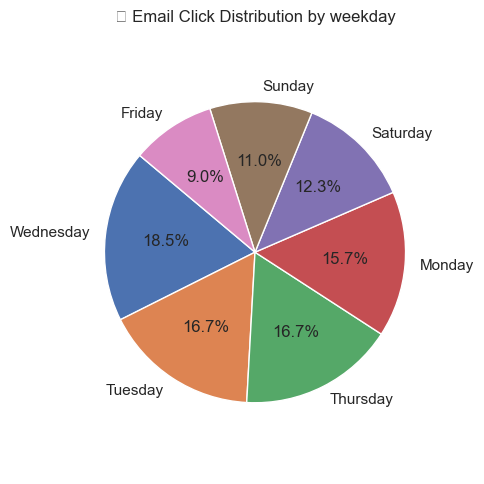

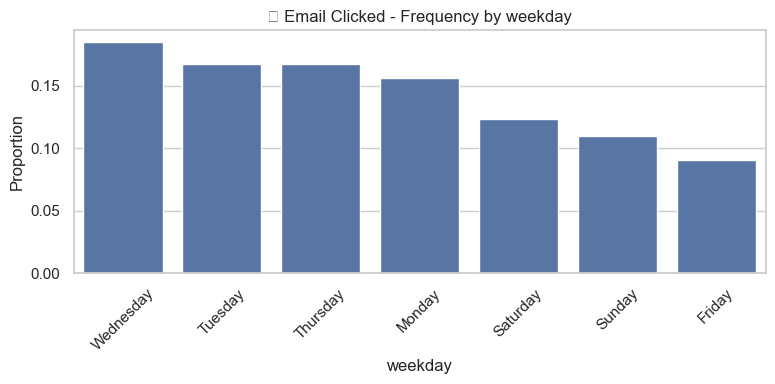

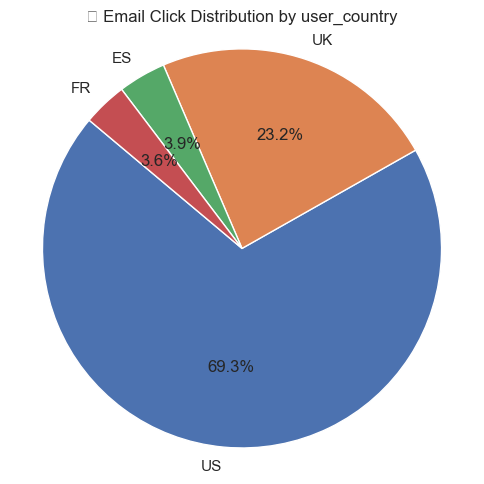

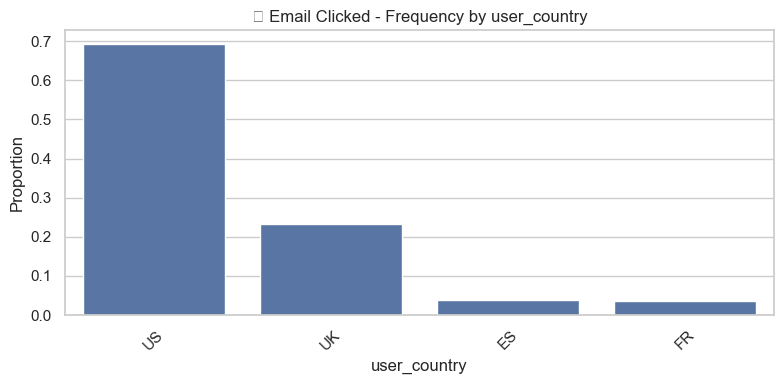

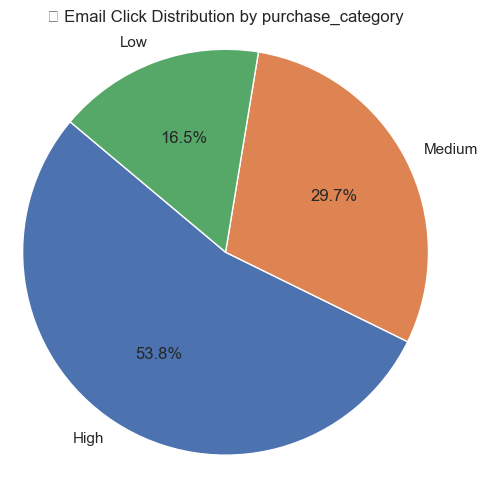

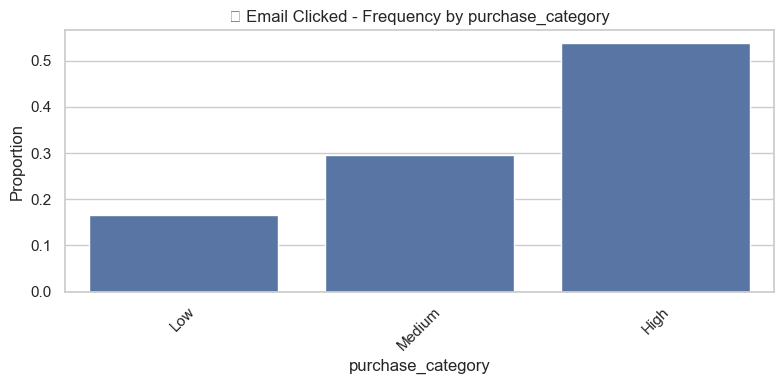

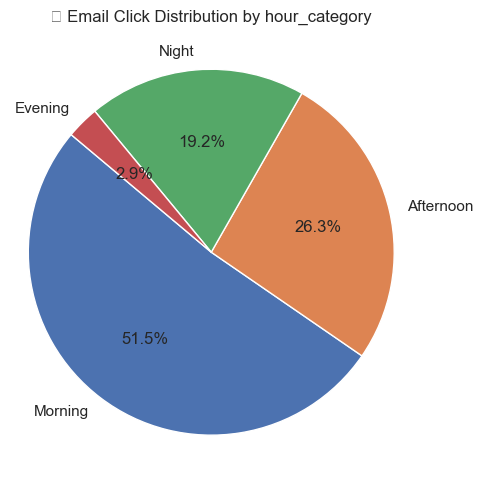

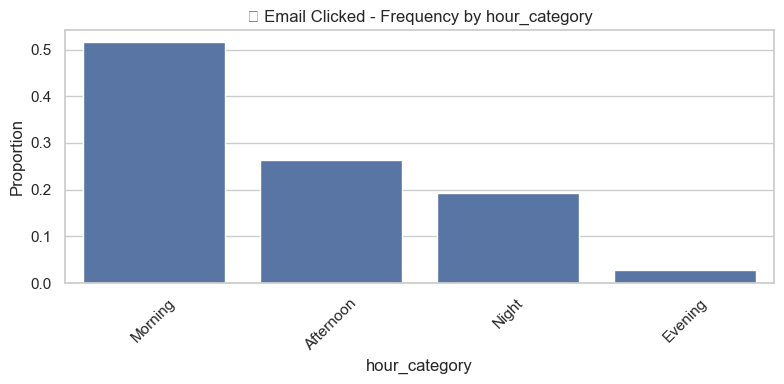

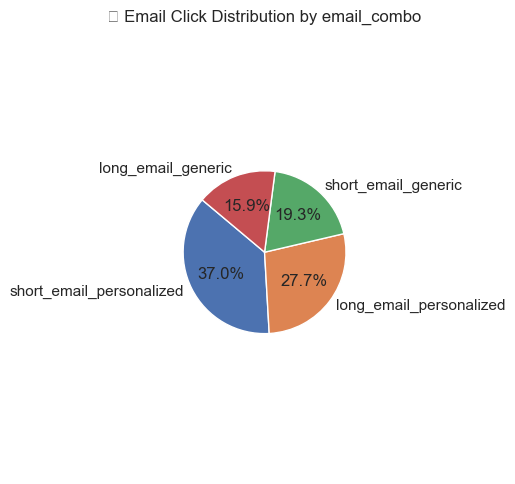

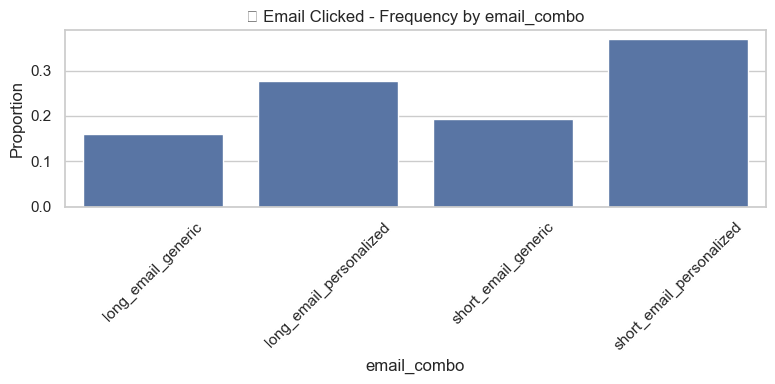

⚠️ Skipping country_hour — too many unique values for pie chart.


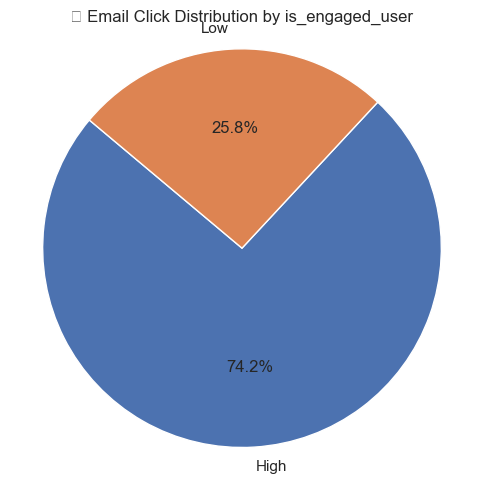

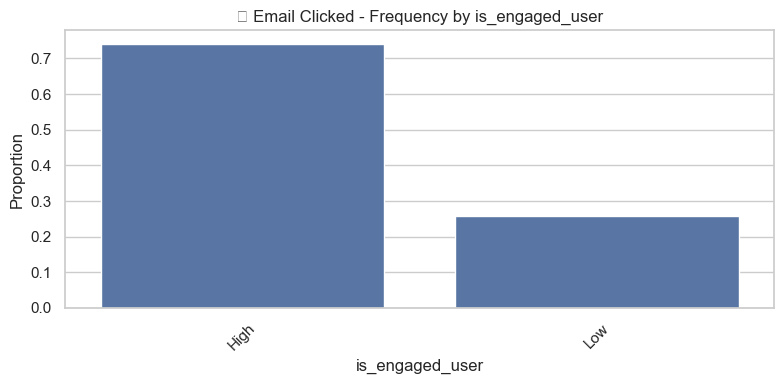

In [32]:
# ------------------------------------------------------------------------------
# 📊 CLICKED EMAIL DISTRIBUTION BY CATEGORICAL FEATURES
#
# Purpose:
# - Visualize how different categorical variables influence email clicks
# - Show pie chart and optional bar chart for each selected categorical column
# ------------------------------------------------------------------------------

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the relevant categorical features for analysis
categorical_columns = [
    'email_text', 'email_version', 'weekday', 'user_country',
    'purchase_category', 'hour_category', 'email_combo',
    'country_hour', 'is_engaged_user'
]

# Filter rows where the email was clicked (opened)
clicked_df = final_merged_df[(final_merged_df['email_clicked'] == 1) & (final_merged_df['link_clicked'] == 1)]
print(f"🟢 Total email_clicked rows: {clicked_df.shape[0]}")

# Loop through selected columns and plot distribution
for col in categorical_columns:
    value_counts = clicked_df[col].value_counts(normalize=True)

    # Skip columns with too many categories (optional)
    if value_counts.shape[0] > 15:
        print(f"⚠️ Skipping {col} — too many unique values for pie chart.")
        continue

    # Plot pie chart
    plt.figure(figsize=(5, 5))
    plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(f'🟢 Email Click Distribution by {col}', fontsize=12)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

    # Optional: also plot a bar chart for comparison
    plt.figure(figsize=(8, 4))
    sns.barplot(x=value_counts.index, y=value_counts.values)
    plt.title(f'📊 Email Clicked - Frequency by {col}', fontsize=12)
    plt.ylabel('Proportion')
    plt.xlabel(col)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


Choose the filter:
1: Users who clicked the email
2: Users who clicked the email and link

📍 Showing results for country: US | Rows: 1434


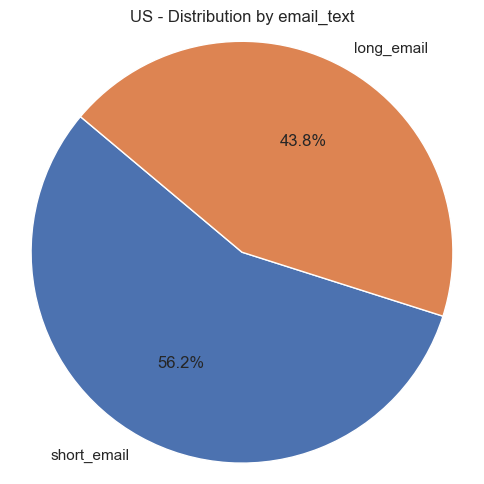

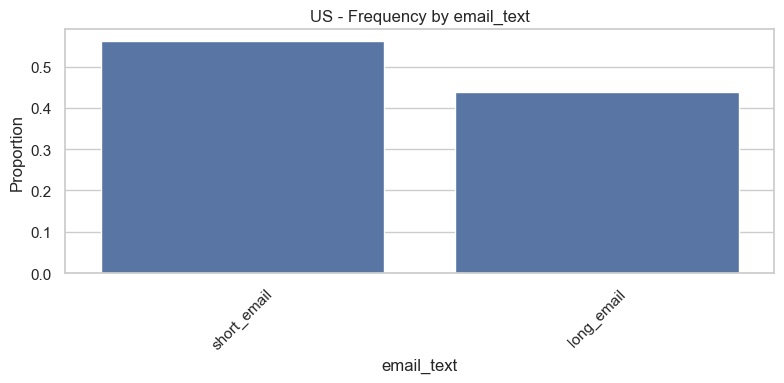

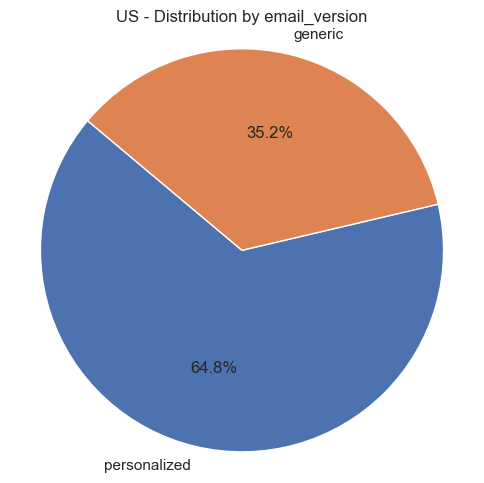

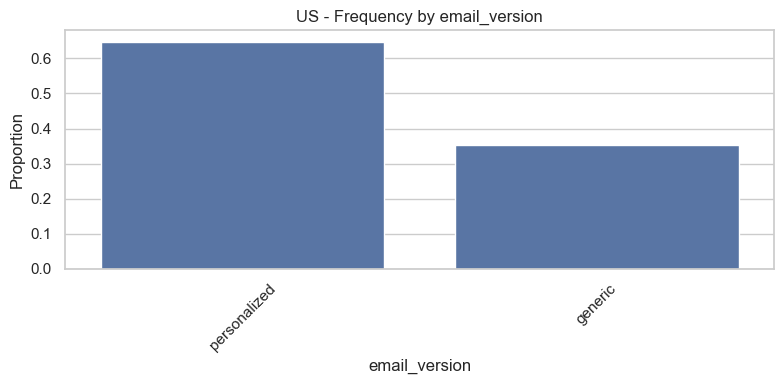

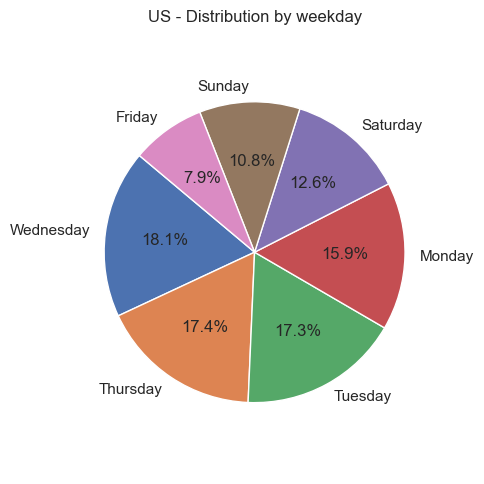

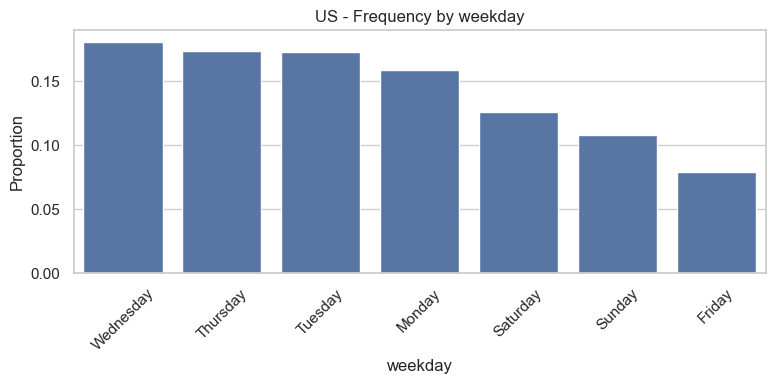

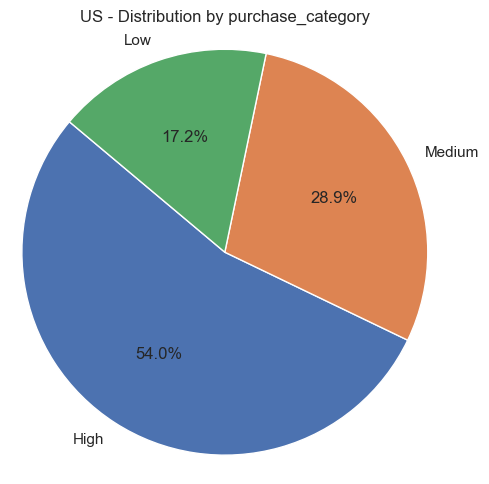

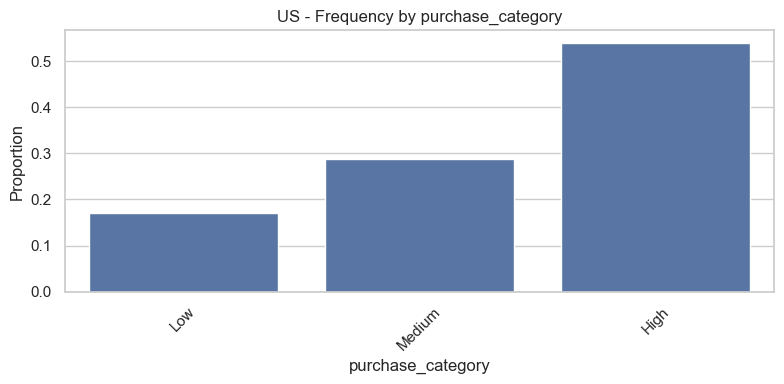

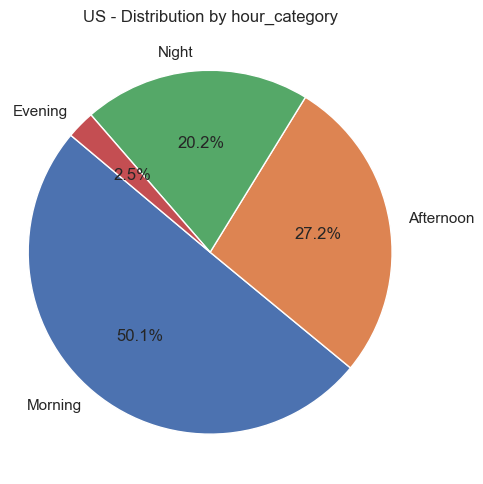

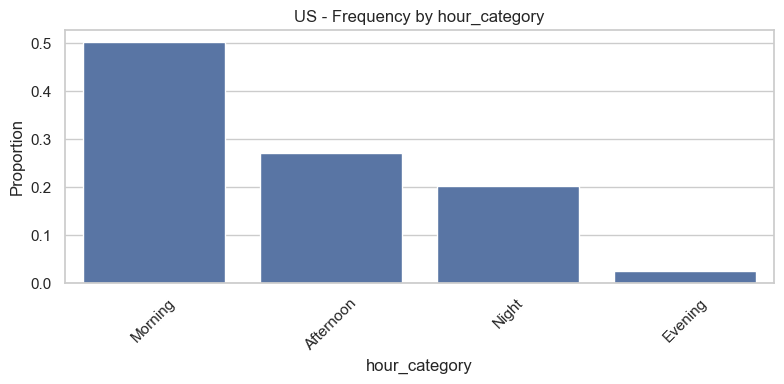

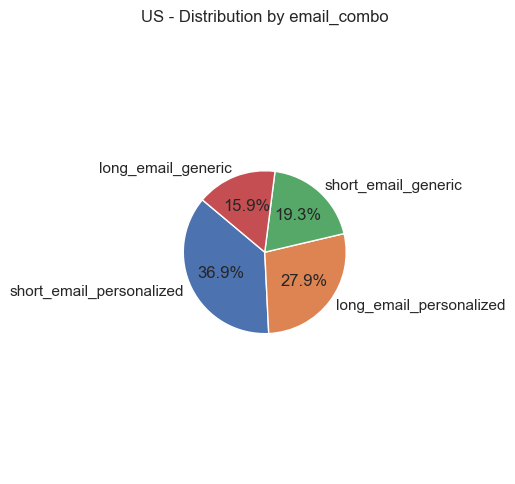

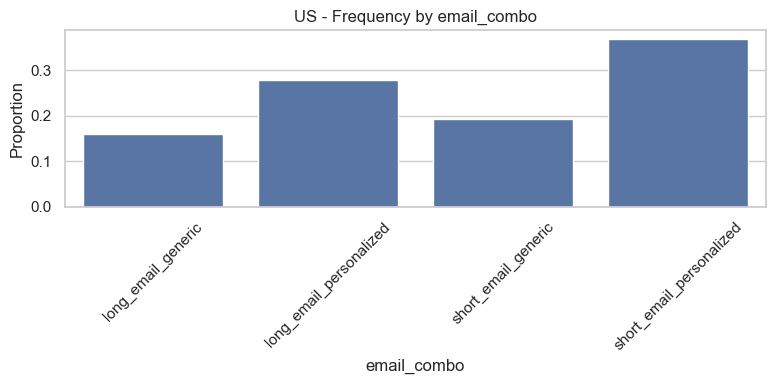

⚠️ Skipping 'country_hour' — too many unique values.


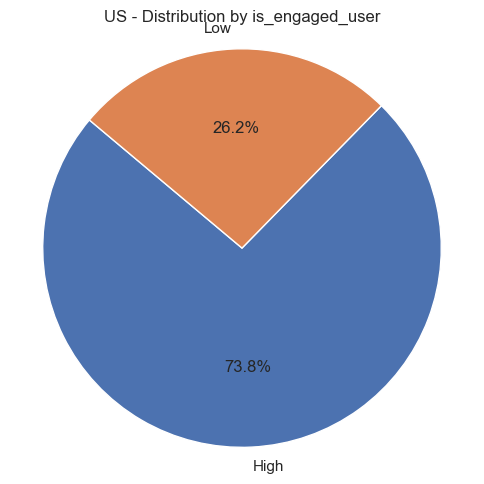

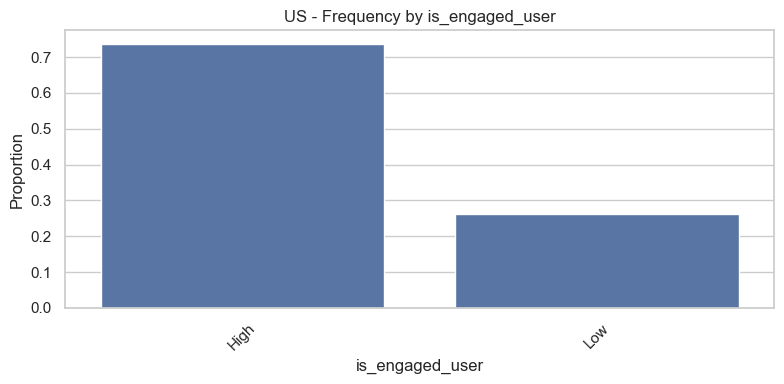

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 🔹 Columns to analyze
categorical_columns = [
    'email_text', 'email_version', 'weekday',
    'purchase_category', 'hour_category', 'email_combo',
    'country_hour', 'is_engaged_user'
]

# 🔹 User options
print("Choose the filter:")
print("1: Users who clicked the email")
print("2: Users who clicked the email and link")

option = input("Enter 1 or 2: ").strip()

if option == "1":
    filtered_df = final_merged_df[final_merged_df['email_clicked'] == 1]
elif option == "2":
    filtered_df = final_merged_df[
        (final_merged_df['email_clicked'] == 1) & 
        (final_merged_df['link_clicked'] == 1)
    ]
else:
    print("❌ Invalid option. Please enter 1 or 2.")
    exit()

# 🔹 Country input
user_input_country = input("Enter a country name (e.g., 'US', 'UK'): ").strip()

# 🔹 Check if valid country
if user_input_country in filtered_df['user_country'].unique():
    country_data = filtered_df[filtered_df['user_country'] == user_input_country]
    print(f"\n📍 Showing results for country: {user_input_country} | Rows: {len(country_data)}")

    for col in categorical_columns:
        if col not in country_data.columns:
            continue

        value_counts = country_data[col].value_counts(normalize=True)

        if value_counts.shape[0] > 15:
            print(f"⚠️ Skipping '{col}' — too many unique values.")
            continue

        # Pie Chart
        plt.figure(figsize=(5, 5))
        plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140)
        plt.title(f'{user_input_country} - Distribution by {col}')
        plt.axis('equal')
        plt.tight_layout()
        plt.show()

        # Bar Chart
        plt.figure(figsize=(8, 4))
        sns.barplot(x=value_counts.index, y=value_counts.values)
        plt.title(f'{user_input_country} - Frequency by {col}')
        plt.ylabel('Proportion')
        plt.xlabel(col)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

else:
    print(f"❌ No data found for country: {user_input_country}")


First, users who received personalized emails had higher click-through rates compared to those who received generic ones.
Second, emails with short text performed better in terms of engagement than those with longer content.
Third, emails sent during the morning hours resulted in more clicks, while those sent in the evening performed poorly.
Finally, users with a past purchase history above the average were more likely to click the link inside the email, showing stronger engagement from previously active customers.